# Diagnostics: mean bias and plotting of difference maps

A notebook to demonstrate the usage of an implemented plotting function in Valenspy

In [1]:
import valenspy as vp
from valenspy._utilities import load_yml
from pathlib import Path

from dask.diagnostics import ProgressBar
from valenspy.preprocessing_tasks.regrid import remap_cdo
from valenspy._regions import sel_region
import warnings
import xarray as xr

# Turn off all warnings
warnings.filterwarnings('ignore')


# define machine name - used for paths of (observational) datasets
machine = 'hortense'



## 0. Settings

In [2]:
model = 'CCLM'
ref_dataset = 'ERA5'
variable = 'tas'

## 1. Loading data

### 1.1 Model data

To be replaced with automatic input manager returning the ds

In [3]:
# get lookup file for model
mod_LOOKUP = load_yml(model+"_lookup")
mod_var = mod_LOOKUP[variable]['mod_name']

experiment = "EUR11_CO_TA_GC_TSO"
postproc_base_dir = "/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/"

# define the path
directory = Path(postproc_base_dir + experiment +'/'+mod_var + '/')

# define the CCLM files for the corresponding variable
mod_files = list(directory.glob(mod_var+"_daymean.nc")) # Select all the netCDF files in the directory
    
ds_mod_raw = xr.open_mfdataset(mod_files, combine="by_coords", chunks="auto")

# renaming to be able to compare
ds_mod_raw = ds_mod_raw.rename({mod_var:variable})
ds_mod_raw.attrs['dataset'] = model
ds_mod_raw[variable].attrs['dataset'] = model

### 1.2. Load reference data

here we will use ERA5

In [4]:
manager = vp.InputManager(machine=machine)

ds_obs = manager.load_data(ref_dataset,variable, period=[1995,1995],freq="hourly",region="europe")


File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/2m_temperature/era5-hourly-europe-2m_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']


## 2. Preprocessing: remapping, resampling and time and region selection
in this example, this means selecting time and remapping

In [5]:
# regrid
# retrieve ERA5 gridfile - for regridding 
gridfile = manager._get_file_paths(ref_dataset,variable, period=[1995,1995],freq="hourly",region="europe")[0]
ds_mod = remap_cdo(gridfile, ds_mod_raw, remap_method = "con")

# resample ERA5 hourly data to daily
ds_obs = ds_obs.resample(time='1D').mean()    

# for both datasets, select summer months (JJA)
ds_mod = ds_mod.sel(time=ds_mod.time.dt.month.isin([6,7,8]))
ds_obs = ds_obs.sel(time=ds_obs.time.dt.month.isin([6,7,8]))

# select the predefined region
region = 'europe'
ds_mod = sel_region(ds_mod, region=region)
ds_obs = sel_region(ds_obs, region=region)

#### check how the observational data looks like using the simple map plotting functionality

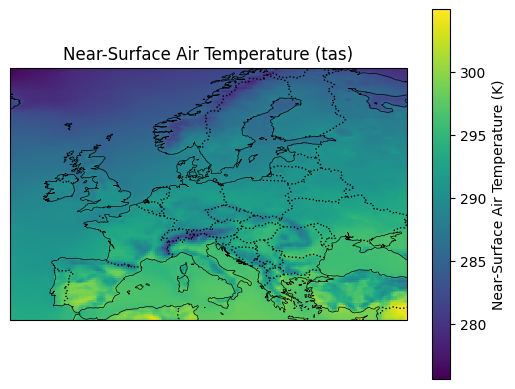

In [6]:
from valenspy.diagnostic_visualizations import plot_map
da_obs = ds_obs['tas'].mean('time')
ax = plot_map(da_obs, region='europe')

Do the same but for Belgium - do note the colorbar range spans all values in the da, which is cut out for Europe now 

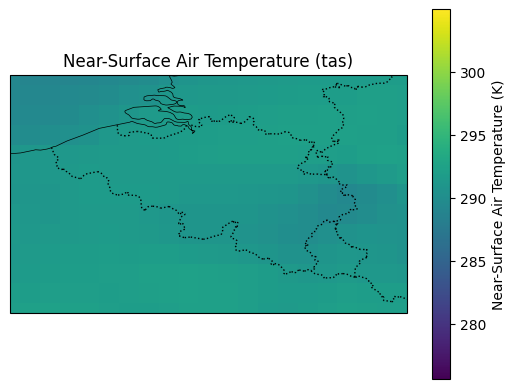

In [7]:
# do the same but for Belgium
ax = plot_map(da_obs, region='belgium')

Now, both datasets are ready to be compared. 

## 3. Calculate the diagnostic and do plotting

First, we will only use the functions and not the diagnostic object


In [7]:
from valenspy.diagnostic_functions import *
from valenspy.diagnostic_visualizations import *

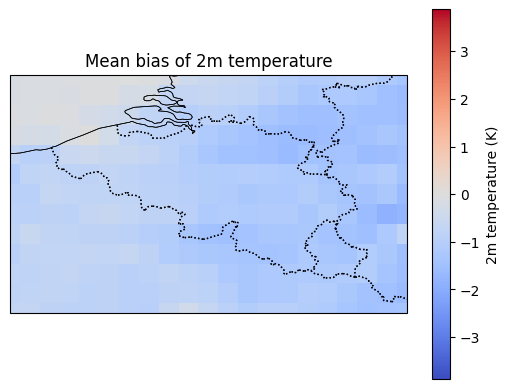

In [ ]:
ds_spatialbias = spatial_bias(ds_mod, ds_obs)
plot_spatial_bias(ds_spatialbias[variable], region='europe'); 

### Use the more elaborate plotting function available in Valenspy

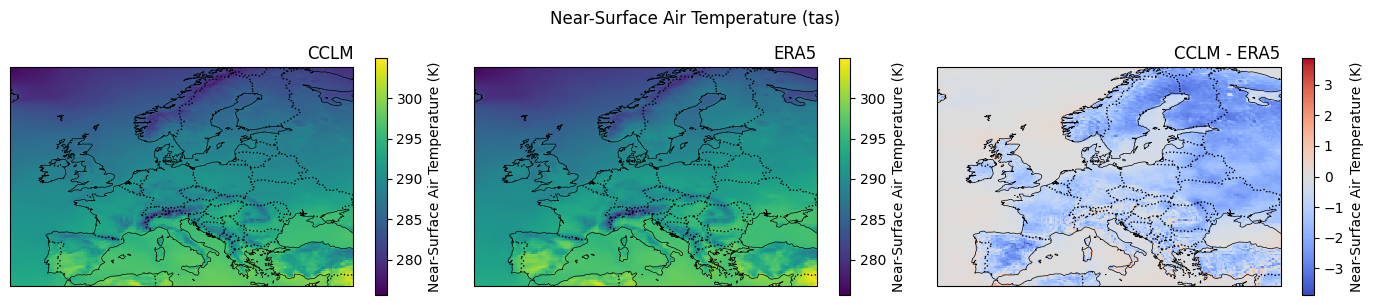

In [10]:
da_mod = ds_mod[variable].mean('time')
da_ref = ds_obs[variable].mean('time')
da_diff = ds_spatialbias[variable]
plot_maps_mod_ref_diff(da_mod,  da_ref,  da_diff, region='europe')

### Now, we will do the same but using the object and its standard plotting function

In [8]:
from valenspy.diagnostic import SpatialBias
print(SpatialBias.description)

Spatial Bias (Model2Ref)
The spatial bias of the data compared to the reference.
 Diagnostic function: spatial_bias
 Calculate the mean spatial bias of the data compared to the reference. The time dimensions are averaged over if present.

    Parameters
    ----------
    ds : xr.Dataset or xr.DataArray
        The data to calculate the spatial bias of.
    ref : xr.Dataset or xr.DataArray
        The reference data to compare the data to.
    calc_relative : bool, optional
        If True, return the relative bias, if False return the absolute bias, by default False

    Returns
    -------
    xr.Dataset or xr.DataArray
        The spatial bias of the data compared to the reference.
    
 Visualization function: plot_spatial_bias
 Plot the spatial bias of the data compared to the reference.


<GeoAxes: title={'center': 'Mean bias of 2m temperature'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

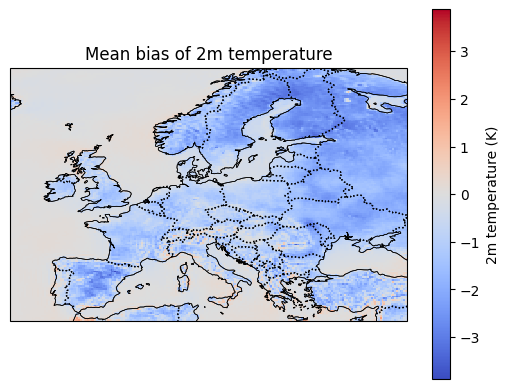

In [9]:
ds_bias = SpatialBias.apply(ds_mod, ds_obs).compute()

SpatialBias.plot(ds_bias[variable])